The base model and some functions were modified to recieve segmentation mask, expand the positional embedding limit of original GPT2 model from 1024 tokens to 2048 tokens, finally prefix attention was added as an option if requiered.

The functions added to GPT2LMHeadModel are

- segmentation_mask: Optional[torch.FloatTensor] = None,  # Shape (batch_size, n_layers, flattened_mask, flattened_mask)
- prefix_allowed_length: Optional[int] = None,            # If not None it uses prefix mask up to prefix length then continues tih causal attention mask
- plot_attention_mask: Optional[bool] = False,            # Plots the attention mask if True
- plot_attention_mask_layer: Optional[list[int]] = [0],   # Plots the attention mask per layer in list
- plot_attention_map: Optional[bool] = False,             # Plots the attention map weights
- plot_attention_map_layer: Optional[list[int]] = [0],    # Plots the attention map weights per layer in list
- plot_attention_map_generation: Optional[int] = 0,       # Plots the attention map weights matrix for inputs if 0, if not 0 then plots the row attention based on generation id token, it should start on inputs_id length. If inputs_id lenght is 1024, then 1024 will plot the attention row for all previous tokens up to first generated token, 1123 will plot attention row fo all previous tokens up to 100th generated token. Ranges for values should be [input_id_length / input_id_length + max generated tokens - 1 ]

In [ ]:
import sys
import os

# Get the absolute path of the 'tutorials' directory
notebook_dir = os.path.abspath('') 

# Get the path to the parent directory (the project root)
project_root = os.path.dirname(notebook_dir)

# Add the project root to the sys.path so we can import utils from the repo
if project_root not in sys.path:
    sys.path.append(project_root)
from utils.models.modifiedGPT2 import create_decoder

Creation of the segmentation masks to correct input size for the modified models.

The masks created by segmentation workflow are recieved in shape (batch_size, 512, 512)
They should be reshaped to a mask of 32x32 and transformed for each layer in the number of Attention layers on GPT2(n_layers=12), the reshaped mask (32x32) needs to be flattened (1024) and then duplicated across rows to create a 4D attention mask used by GPT2.
 
The modified model recieves segmentation mask in shape (batch_size, n_layer, 1024, 1024)

stacked: torch.Size([2, 12, 32, 32])
flat:    torch.Size([2, 12, 1024])
tiled:   torch.Size([2, 12, 1024, 1024])


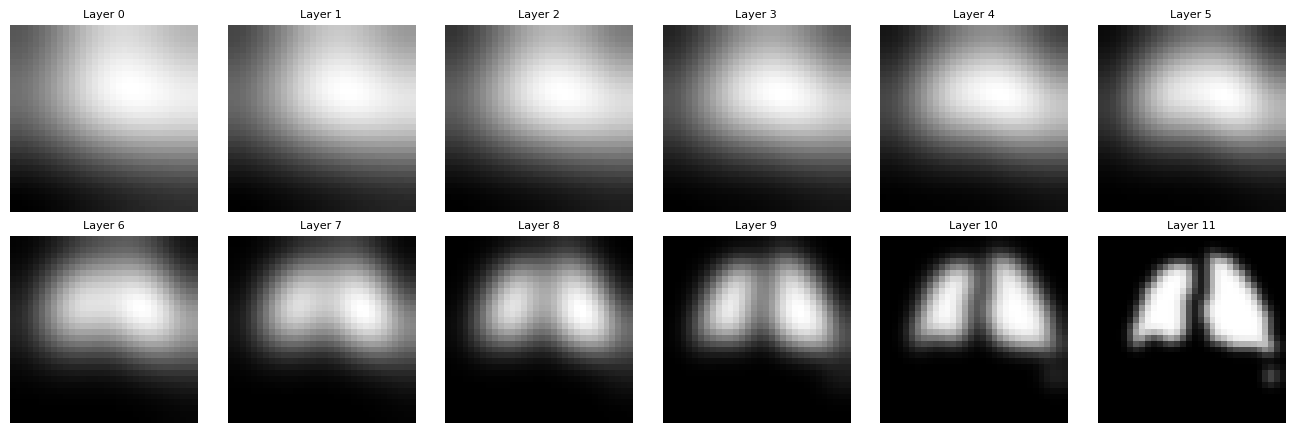

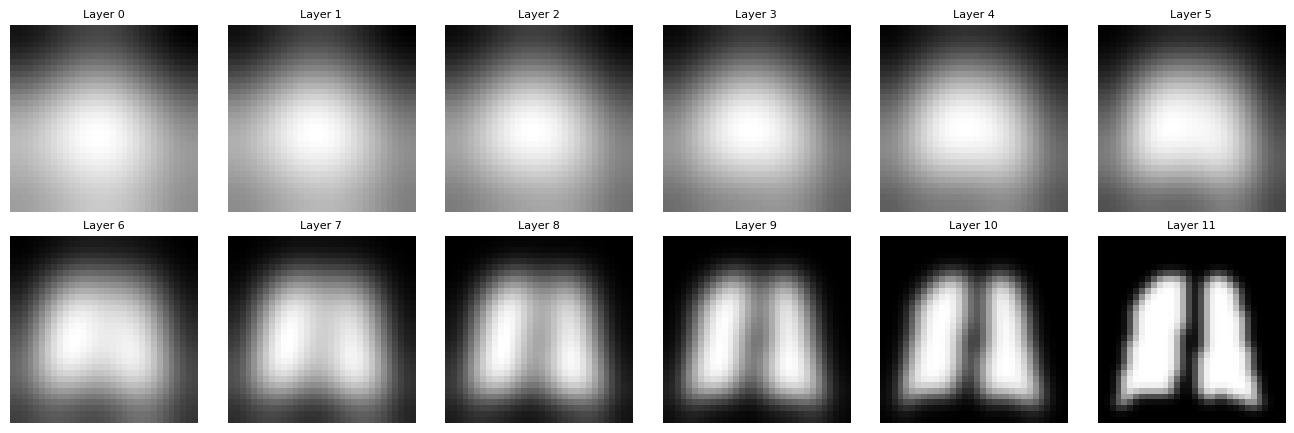

In [2]:
# -*- coding: utf-8 -*-
import os
import math
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ============================================================
# Utils
# ============================================================
def normalize01_torch(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Normaliza por muestra a [0,1].
    Acepta: (B, H, W) o (B, 1, H, W)
    Devuelve: (B, 1, H, W)
    """
    if x.ndim == 3:        # (B,H,W) -> (B,1,H,W)
        x = x.unsqueeze(1)
    xmin = x.amin(dim=(2,3), keepdim=True)
    xmax = x.amax(dim=(2,3), keepdim=True)
    denom = (xmax - xmin).clamp_min(eps)
    y = (x - xmin) / denom
    # Asegurar 1 canal
    if y.shape[1] != 1:
        y = y[:, :1]
    return y

def _ensure_odd(k: int) -> int:
    k = max(int(k), 1)
    return k if (k % 2 == 1) else (k + 1)

def gaussian_kernel1d_torch(ksize: int, sigma: float | None = None, device=None, dtype=None) -> torch.Tensor:
    """
    1D Gaussian kernel normalizado (suma 1), tamaño impar.
    """
    k = _ensure_odd(ksize)
    if sigma is None or sigma <= 0:
        sigma = (k - 1) / 6.0
    r = k // 2
    x = torch.arange(-r, r + 1, device=device, dtype=torch.float32 if dtype is None else dtype)
    g = torch.exp(-(x**2) / (2.0 * sigma * sigma))
    g = g / g.sum()
    return g  # (k,)

def gaussian_blur2d_with_ksize_torch(x: torch.Tensor, ksize: int, sigma: float | None = None) -> torch.Tensor:
    """
    Desenfoque gaussiano separable 2D con padding reflect.
    x: (B,1,H,W)
    return: (B,1,H,W)
    """
    B, C, H, W = x.shape
    assert C == 1, "Se espera 1 canal"
    device, dtype = x.device, x.dtype

    k1 = gaussian_kernel1d_torch(ksize, sigma, device=device, dtype=dtype)  # (K,)
    pad = k1.numel() // 2

    # Conv horizontal (1xK)
    xh = F.pad(x, (pad, pad, 0, 0), mode="reflect")
    weight_h = k1.view(1, 1, 1, -1)                                        # (outC,inC,1,K)
    xh = F.conv2d(xh, weight_h)

    # Conv vertical (Kx1)
    xv = F.pad(xh, (0, 0, pad, pad), mode="reflect")
    weight_v = k1.view(1, 1, -1, 1)                                        # (outC,inC,K,1)
    out = F.conv2d(xv, weight_v)
    return out

# ============================================================
# Reducción a 32x32 (acepta cualquier HxW)
# ============================================================
def resize_to_32(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B, H, W) -> (B, 32, 32)
    """
    if x.ndim != 3:
        raise ValueError(f"Expected (B,H,W), got {tuple(x.shape)}")
    x = x.float().unsqueeze(1)  # (B,1,H,W)
    x = F.interpolate(x, size=(32, 32), mode="bilinear", align_corners=False)
    return x.squeeze(1)         # (B,32,32)

# ============================================================
# Filtro por capa con schedule de ksize
# ============================================================
def apply_filter(x32: torch.Tensor,
                 layer_idx: int,
                 base_ksize: int = 3,
                 ksize_growth: int = 2,
                 sigma: float | None = None) -> torch.Tensor:
    """
    x32: (B,32,32)
    Normaliza a [0,1], aplica blur gaussiano con ksize creciente por capa y regresa (B,32,32).
    """
    x_norm = normalize01_torch(x32).to(x32.dtype)   # (B,1,32,32)
    ksize = _ensure_odd(base_ksize + layer_idx * ksize_growth)
    y = gaussian_blur2d_with_ksize_torch(x_norm, ksize=ksize, sigma=sigma)  # (B,1,32,32)
    y = normalize01_torch(y).squeeze(1)                                     # (B,32,32)
    return y

def build_layer_stack(x32: torch.Tensor, n_layers: int,
                      base_ksize: int = 3, ksize_growth: int = 2, sigma: float | None = None) -> torch.Tensor:
    """
    Aplica apply_filter() n_layers veces y apila:
    Entrada:  x32 (B,32,32)
    Salida:   (B, n_layers, 32, 32)
    """
    layers = []
    for i in range(n_layers, 0, -1):  # capas n_layers ... 1
        y = apply_filter(x32, layer_idx=i, base_ksize=base_ksize, ksize_growth=ksize_growth, sigma=sigma)  # (B,32,32)
        layers.append(y.unsqueeze(1))  # (B,1,32,32)
    return torch.cat(layers, dim=1)    # (B,n_layers,32,32)

# ============================================================
# Flatten + Tile
# ============================================================
def flatten_and_tile(x_layers: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """
    x_layers: (B, n_layers, 32, 32)
      -> flat:  (B, n_layers, 1024)
      -> tiled: (B, n_layers, 1024, 1024)  (repitiendo valores a lo largo de la última nueva dimensión)
    """
    B, L, H, W = x_layers.shape
    if (H, W) != (32, 32):
        raise ValueError("Expected spatial size 32x32 before flatten.")
    flat = x_layers.reshape(B, L, H * W)                  # (B,L,1024)
    tiled = flat.unsqueeze(-2).expand(-1, -1, H * W, -1)   # (B,L,1024,1024) tile[0,0,:,j] = flat[0,0,:] for all j
    return flat, tiled

# ============================================================
# Pipeline completo
# ============================================================
def pipeline(x: torch.Tensor, n_layers: int,
             base_ksize: int = 3, ksize_growth: int = 2, sigma: float | None = None):
    """
    x: (B,H,W)  [cualquier HxW]
    Retorna:
      - stacked: (B, n_layers, 32, 32)
      - flat:    (B, n_layers, 1024)
      - tiled:   (B, n_layers, 1024, 1024)
    """
    x32 = resize_to_32(x)                                                # (B,32,32)
    stacked = build_layer_stack(x32, n_layers, base_ksize, ksize_growth, sigma)  # (B,n_layers,32,32)
    flat, tiled = flatten_and_tile(stacked)
    return stacked, flat, tiled

# ============================================================
# Visualización: plot de stacked[sample_idx] en gris
# ============================================================
def plot_stacked_layers(stacked: torch.Tensor, sample_idx: int = 0, cols: int = 6, save_path: str | None = None):
    """
    Muestra en gris cada capa de stacked[sample_idx] en una grilla.
    stacked: (B, n_layers, 32, 32)
    sample_idx: índice del batch a mostrar (default 0)
    cols: columnas de la grilla
    save_path: si no es None, guarda la figura en esa ruta
    """
    if stacked.ndim != 4:
        raise ValueError(f"Expected (B, n_layers, H, W), got {tuple(stacked.shape)}")

    B, L, H, W = stacked.shape
    if sample_idx < 0 or sample_idx >= B:
        raise IndexError(f"sample_idx out of range: {sample_idx} (B={B})")

    imgs = stacked[sample_idx].detach().cpu().numpy().astype(np.float32)  # (L,H,W)

    # Normaliza cada capa a [0,1] individualmente
    mn = imgs.min(axis=(1, 2), keepdims=True)
    mx = imgs.max(axis=(1, 2), keepdims=True)
    denom = np.where((mx - mn) < 1e-8, 1.0, (mx - mn))
    imgs_norm = (imgs - mn) / denom  # (L,H,W) en [0,1]

    rows = math.ceil(L / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    axes = np.atleast_2d(axes).reshape(rows, cols)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        ax.axis('off')
        if i < L:
            ax.imshow(imgs_norm[i], cmap='gray', vmin=0.0, vmax=1.0)
            ax.set_title(f"Layer {i}", fontsize=8)
        else:
            ax.imshow(np.zeros((H, W), dtype=np.float32), cmap='gray', vmin=0.0, vmax=1.0)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    return fig

# ============================================================
# Data loader simple desde carpeta (masks en escala de grises)
# ============================================================
mask_path   = "datasets/MIMIC/matched_images_and_masks_mimic_224/masks"
image_type  = ".jpg"

def load_mask_tensor(mask_id: str, target_hw=None) -> torch.Tensor:
    """
    Carga una máscara en escala de grises, normaliza a [0,1] y la redimensiona opcionalmente a target_hw.
    Retorna un tensor float32 shape (H, W).
    """
    full_path = os.path.join(mask_path, f"{mask_id}{image_type}")
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"No existe: {full_path}")

    with Image.open(full_path) as im:
        im = im.convert("L")  # gris 0..255
        arr = np.array(im, dtype=np.float32) / 255.0
        t = torch.from_numpy(arr)  # (H0,W0), float32 CPU

    if target_hw is not None:
        Ht, Wt = target_hw
        t = t.unsqueeze(0).unsqueeze(0)  # (1,1,H0,W0)
        t = F.interpolate(t, size=(Ht, Wt), mode="bilinear", align_corners=False)
        t = t.squeeze(0).squeeze(0)     # (Ht,Wt)

    return t.clamp(0.0, 1.0)

def build_batch_from_folder(B: int, target_hw=None) -> torch.Tensor:
    """
    Toma los primeros B archivos del folder y arma un batch (B,H,W).
    Si target_hw es None, mantiene el tamaño original de cada imagen; en ese caso
    se requiere que todas tengan el mismo HxW para poder stackear.
    """
    files = sorted([f for f in os.listdir(mask_path) if f.endswith(image_type)])
    if len(files) < B:
        raise ValueError(f"Se pidieron B={B} máscaras pero solo hay {len(files)} en {mask_path}")

    batch_tensors = []
    for i in range(B):
        mask_id = os.path.splitext(files[i])[0]
        t = load_mask_tensor(mask_id, target_hw=target_hw)  # (H,W)
        batch_tensors.append(t)

    x = torch.stack(batch_tensors, dim=0)  # (B,H,W)
    return x

# ============================================================
# Ejecución de ejemplo
# ============================================================
if __name__ == "__main__":
    # Parámetros
    B = 2
    n_layers = 12
    BASE_KSIZE = 3
    KSIZE_GROW = 4
    SIGMA = None  # heurística

    # Construir batch; puedes fijar target_hw=(224,224) o dejar None si ya son iguales
    x = build_batch_from_folder(B, target_hw=(224, 224))  # -> (B,224,224)

    # (Opcional) mover a GPU
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # x = x.to(device)

    stacked, flat, tiled = pipeline(x, n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
    print("stacked:", stacked.shape)  # (B,12,32,32)
    print("flat:   ", flat.shape)     # (B,12,1024)
    print("tiled:  ", tiled.shape)    # (B,12,1024,1024)

    # Graficar el primer elemento del batch
    for b in range(B):
        plot_stacked_layers(stacked, sample_idx=b, cols=6)
        plt.show()


To check if the creation of the masks was done correclty it can be checked by reshaping from the flatttened 1024 to 32x32 mask and then plotted, the mask should be the same for flattened mask and mas reshaped from segmentation mask the modified model recieves

Is tiles stacked flats? True


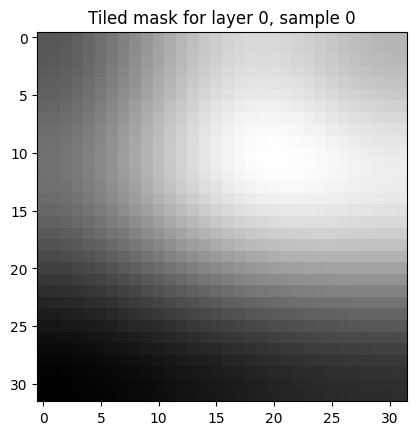

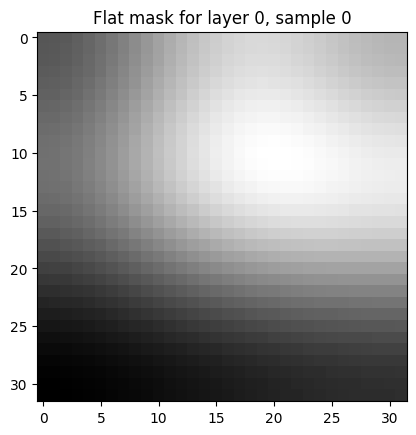

In [3]:
print("Is tiles stacked flats?", torch.equal(tiled[0][0][0][:], flat[0][0]))
plt.imshow(tiled[0,0,0,:].cpu().numpy().reshape(32,32), cmap='gray')
plt.title("Tiled mask for layer 0, sample 0")
plt.show()
plt.imshow(flat[0,0].cpu().numpy().reshape(32,32), cmap='gray')
plt.title("Flat mask for layer 0, sample 0")
plt.show()

To test the modified model and the added functions we compare the results with and without segmentation to see if the result is different, there is also the comparison between eager and sdpa attention implementations to check that both implementations return the same results, so we can use the sdpa when we dont wnat to output attentions and take advantage of its perfomance, and eager when we want to see the attention weights.

ALL ANSWERS TO THE COMPARISONS MUST BE TRUE

In [4]:
model = create_decoder(attention="sdpa")
eager_model = create_decoder(attention="eager")

vocab = model.config.vocab_size
input_ids = torch.randint(low=0, high=vocab, size=(2, 1024), dtype=torch.long) 
image_encoder_masks = tiled
length_input = input_ids.shape[1]
attention_mask = torch.ones((B, length_input), dtype=torch.float32)

model_outputs_sdpa = model(input_ids)
model_outputs_sdpa_plus_segmentation = model(input_ids, segmentation_mask=tiled)
model_outputs_sdpa_plus_segmentation_plus_prefix = model(input_ids, segmentation_mask=tiled, prefix_allowed_length=512)
model_outputs_eager = eager_model(input_ids)
model_outputs_eager_plus_segmentation = eager_model(input_ids, segmentation_mask=tiled)
model_outputs_eager_plus_segmentation_output = eager_model(input_ids, segmentation_mask=tiled, output_attentions=True)
model_outputs_eager_plus_segmentation_plus_prefix = eager_model(input_ids, segmentation_mask=tiled, prefix_allowed_length=512)
model_outputs_eager_plus_segmentation_plus_prefix_output = eager_model(input_ids, segmentation_mask=tiled, output_attentions=True, prefix_allowed_length=512)
print("Is output equal when using sdpa vs eager attention?", torch.equal(model_outputs_sdpa[0], model_outputs_eager[0]))
print("Is output equal when using sdpa + segmentation vs eager + segmentation?", torch.equal(model_outputs_sdpa_plus_segmentation[0], model_outputs_eager_plus_segmentation[0]))
print("Is output different when using segmentation mask on sdpa?", not torch.equal(model_outputs_sdpa[0], model_outputs_sdpa_plus_segmentation[0]))
print("Is output different when using segmentation mask on eager?", not torch.equal(model_outputs_eager[0], model_outputs_eager_plus_segmentation[0]))
print("Is output equal when using sdpa + segmentation + prefix vs eager + segmentation + prefix?", torch.equal(model_outputs_sdpa_plus_segmentation_plus_prefix[0], model_outputs_eager_plus_segmentation_plus_prefix[0]))

Is output equal when using sdpa vs eager attention? True
Is output equal when using sdpa + segmentation vs eager + segmentation? True
Is output different when using segmentation mask on sdpa? True
Is output different when using segmentation mask on eager? True
Is output equal when using sdpa + segmentation + prefix vs eager + segmentation + prefix? True


Attention map plot, if causal the upper triangular of map should be blank.

--------------------------------
Attention map with causal attention masking
---------------------------------


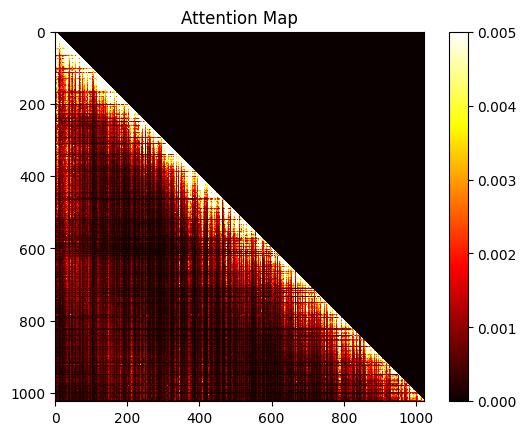

--------------------------------
Attention map with prefix mask (up to 512) + causal attention masking
---------------------------------


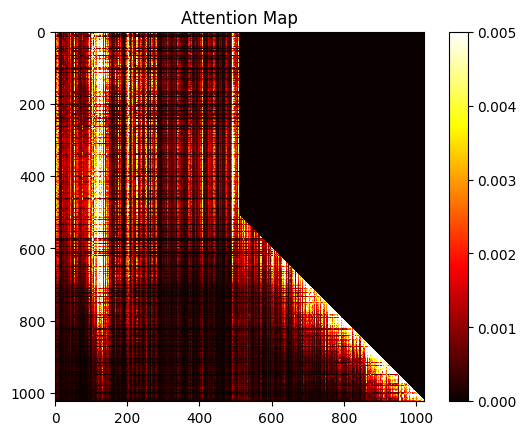

In [5]:
layer_idx = 11
batch_idx = 0
head_idx = 1
query_idx = 512
key_idx = 20

print("--------------------------------")
print("Attention map with causal attention masking")
print("---------------------------------")
attention_map = np.array(model_outputs_eager_plus_segmentation_output.attentions[layer_idx][batch_idx][:][:][:].detach().cpu().numpy())
reshaped_attention_map = attention_map.mean(axis=0)  # Mean over heads
plt.imshow(reshaped_attention_map, cmap='hot', interpolation='nearest', vmin=0.0, vmax=0.005)
plt.title("Attention Map")
plt.colorbar()
plt.show()

print("--------------------------------")
print("Attention map with prefix mask (up to 512) + causal attention masking")
print("---------------------------------")
attention_map = np.array(model_outputs_eager_plus_segmentation_plus_prefix_output.attentions[layer_idx][batch_idx][:][:][:].detach().cpu().numpy())
reshaped_attention_map = attention_map.mean(axis=0)  # Mean over heads
plt.imshow(reshaped_attention_map, cmap='hot', interpolation='nearest', vmin=0.0, vmax=0.005)
plt.title("Attention Map")
plt.colorbar()
plt.show()

Attention plot for query idx resize to original image size to represent how much attention does the query attend to the keys in the image. If causal it should be up to query idx but if prefix was used it should be up to the max(prefix, quey idx)

--------------------------------
Attention map with causal attention masking
---------------------------------


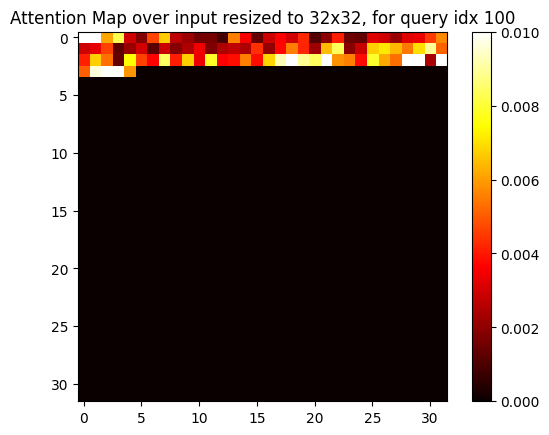

--------------------------------
Attention map with prefix mask (up to 512) + causal attention masking
---------------------------------


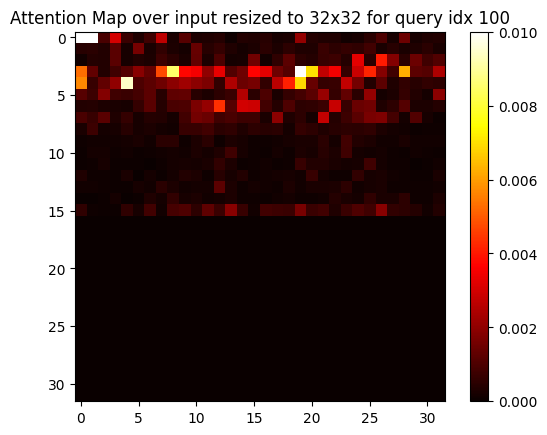

In [6]:
layer_idx = 11
batch_idx = 0
head_idx = 1
query_idx = 100

print("--------------------------------")
print("Attention map with causal attention masking")
print("---------------------------------")
attention_map = np.array(model_outputs_eager_plus_segmentation_output.attentions[layer_idx][batch_idx][:][:][:].detach().cpu().numpy())
reshaped_attention_map = attention_map.mean(axis=0)  # Mean over heads
resized_attention_map = reshaped_attention_map[query_idx].reshape(32,32)
plt.imshow(resized_attention_map, cmap='hot', interpolation='nearest', vmin=0.0, vmax=0.01)
plt.title(f"Attention Map over input resized to 32x32, for query idx {query_idx}")
plt.colorbar()
plt.show()

print("--------------------------------")
print("Attention map with prefix mask (up to 512) + causal attention masking")
print("---------------------------------")
attention_map = np.array(model_outputs_eager_plus_segmentation_plus_prefix_output.attentions[layer_idx][batch_idx][:][:][:].detach().cpu().numpy())
reshaped_attention_map = attention_map.mean(axis=0)  # Mean over heads
resized_attention_map = reshaped_attention_map[query_idx].reshape(32,32)
plt.imshow(resized_attention_map, cmap='hot', interpolation='nearest', vmin=0.0, vmax=0.01)
plt.title(f"Attention Map over input resized to 32x32 for query idx {query_idx}")
plt.colorbar()
plt.show()

Plot of attention mask for layers 0 and 6 

Block 0: segmentation mask added to causal mask.


c:\Users\emman\Desktop\PROYECTOS_VS_CODE\PRUEBAS_DE_PYTHON\Chest-X-ray-Diagnosis-Automated-Reporting-using-CNNs-and-LLMs---UDEM-PEF-Thesis-Fall-2025\venv-chest\lib\site-packages\matplotlib\colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


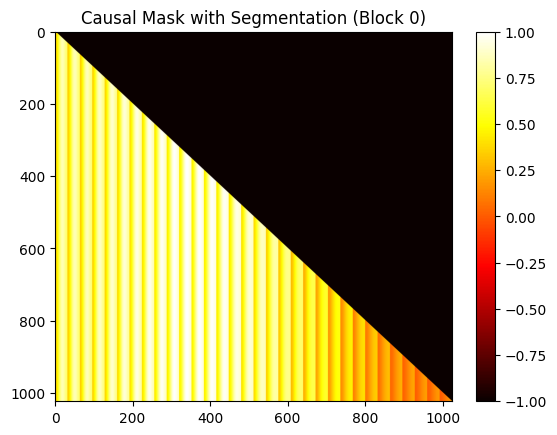

Block 6: segmentation mask added to causal mask.


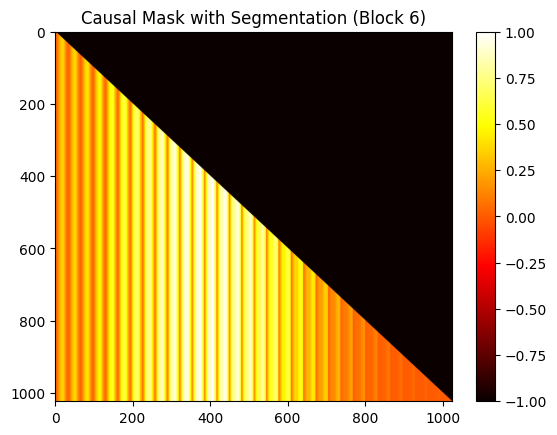

In [7]:
_ = eager_model(input_ids, 
                segmentation_mask=tiled,
                prefix_allowed_length=0, 
                plot_attention_mask=True, 
                plot_attention_mask_layer=[0, 6])

Plot of attention prefix mask for layers 0 and 6 

Block 0: segmentation mask added to causal mask.


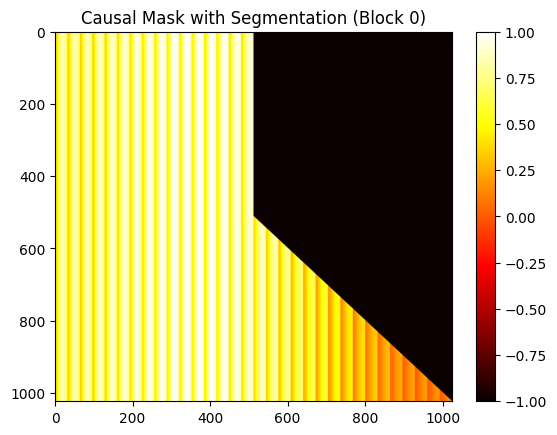

Block 6: segmentation mask added to causal mask.


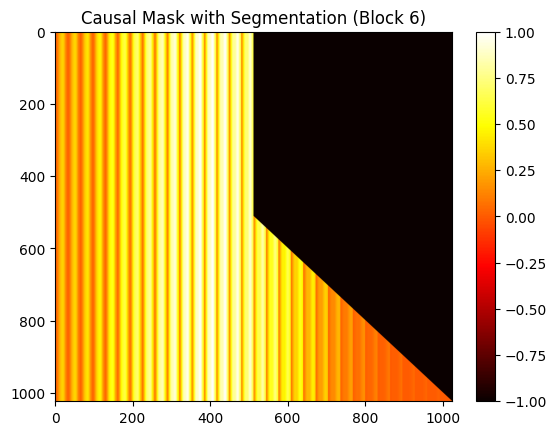

In [8]:
_ = eager_model(input_ids, 
                segmentation_mask=tiled, 
                prefix_allowed_length=512, 
                plot_attention_mask=True, 
                plot_attention_mask_layer=[0, 6])

Testing the generation of the modified model

In [9]:
import torch
from transformers import GPT2Tokenizer
from utils.models.modifiedGPT2 import create_decoder

model_name = "gpt2"  # try "gpt2-medium", "gpt2-large" for higher quality
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer & model
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = create_decoder(attention="eager").to(device)
model.eval()

# GPT-2 has no pad_token by default; map pad -> eos to avoid warnings in batched gen
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

vocab = model.config.vocab_size
input_ids = torch.randint(low=0, high=vocab, size=(2, 1024), dtype=torch.long)  # Ejemplo de tensores de salida del codificador de imágenes
segmentation_mask = tiled

inputs = torch.randint(low=0, high=vocab, size=(2, 1024), dtype=torch.long).to(device)
with torch.no_grad():
    output_ids = model.generate(
        inputs,
        max_new_tokens=100,
        do_sample=False,           # False -> greedy / beams
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        # segmentation_mask=segmentation_mask.to(device),
        # prefix_allowed_length=1024,
        # output_attentions=True,
    )
print(tokenizer.decode(output_ids[0][1024:], skip_special_tokens=True))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


 the world's most important thing, not a single one of them. The only ones who are still alive and well in this universe?
Posted by: Anonymous on May 19th 2013 at 12 : 02 Reply


Plot of attention weights map for layer 0 and 6

Plotting attention map for inputs on layer 0


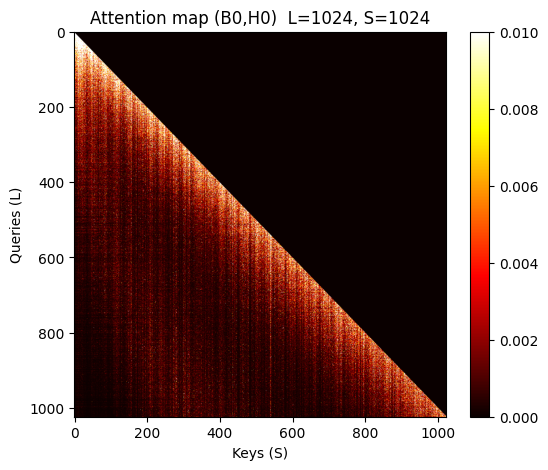

Plotting attention map for inputs on layer 6


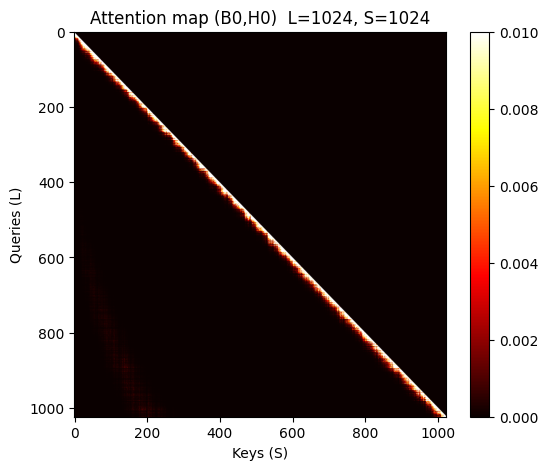

In [10]:
_ = eager_model(input_ids, 
                segmentation_mask=tiled,
                prefix_allowed_length=0,
                plot_attention_mask=False, 
                plot_attention_map=True, 
                plot_attention_map_layer=[0, 6], 
                plot_attention_map_generation=0)

Plot of attention weights map for layer 0 and 6 for generated token 10

Plotting attention row map for token 1033 generation on layer 0


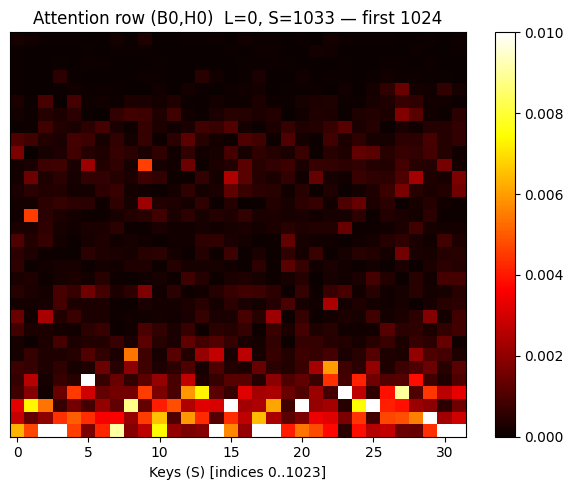

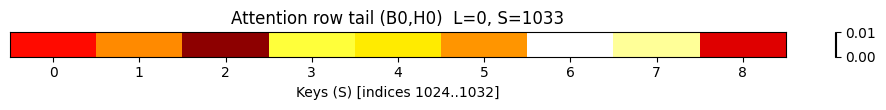

Plotting attention row map for token 1033 generation on layer 1


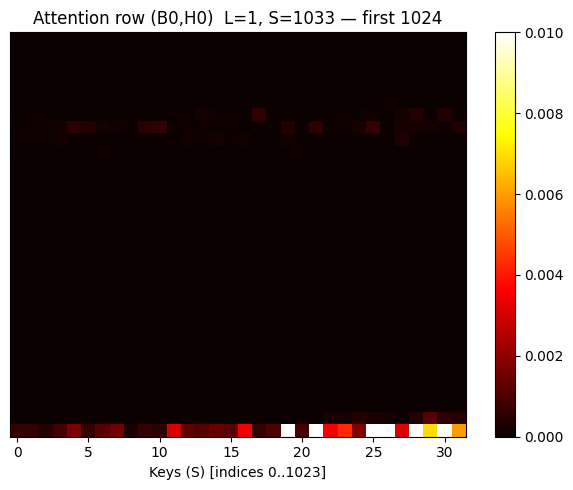

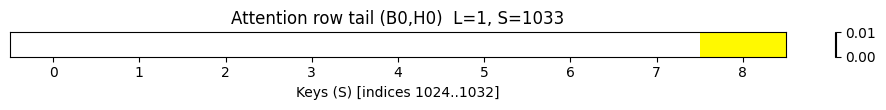

Plotting attention row map for token 1033 generation on layer 2


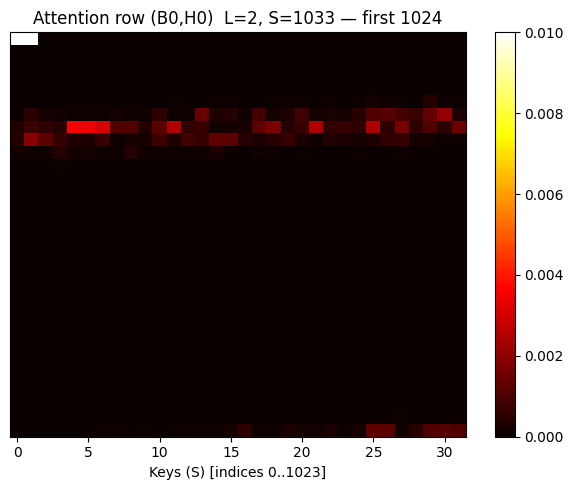

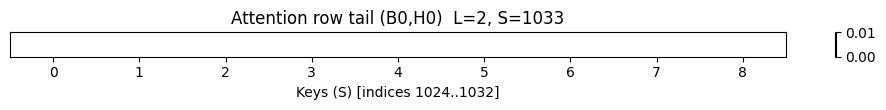

Plotting attention row map for token 1033 generation on layer 3


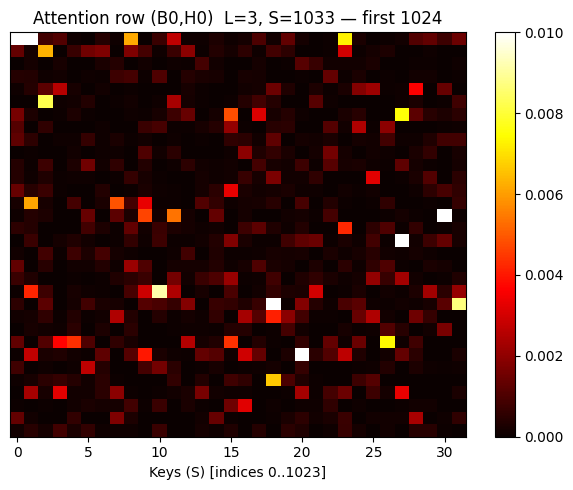

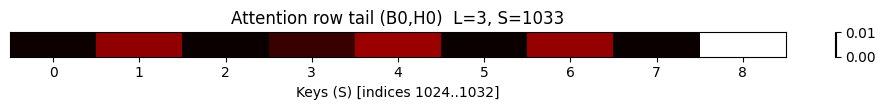

Plotting attention row map for token 1033 generation on layer 4


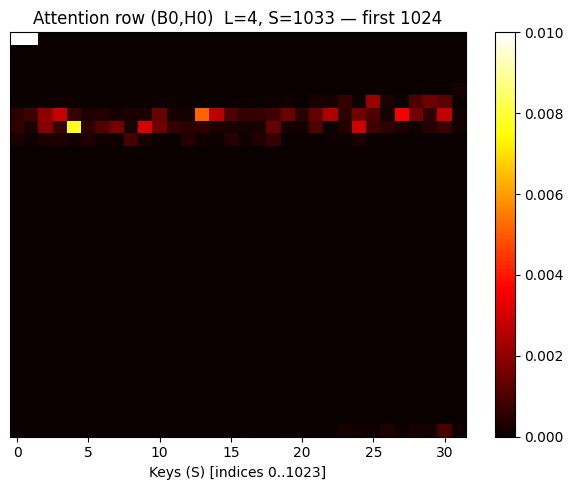

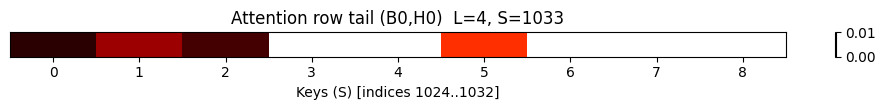

Plotting attention row map for token 1033 generation on layer 5


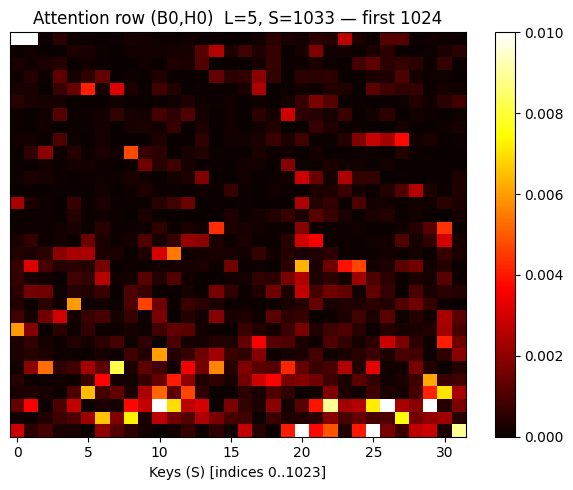

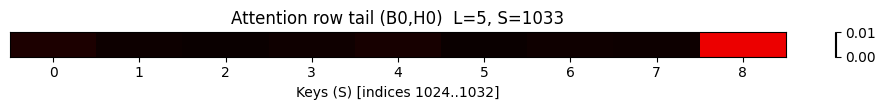

Plotting attention row map for token 1033 generation on layer 6


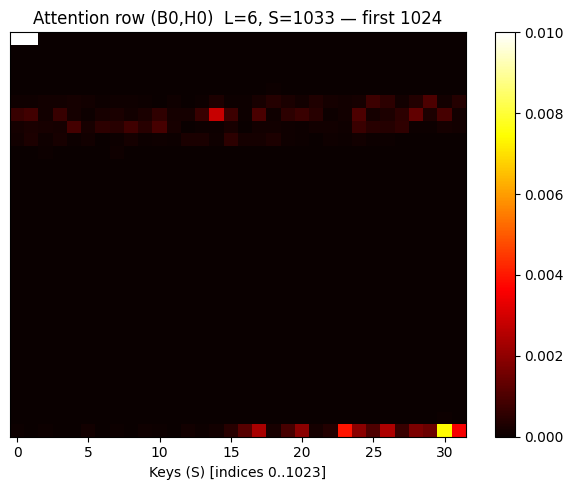

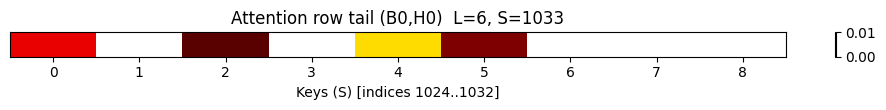

Plotting attention row map for token 1033 generation on layer 7


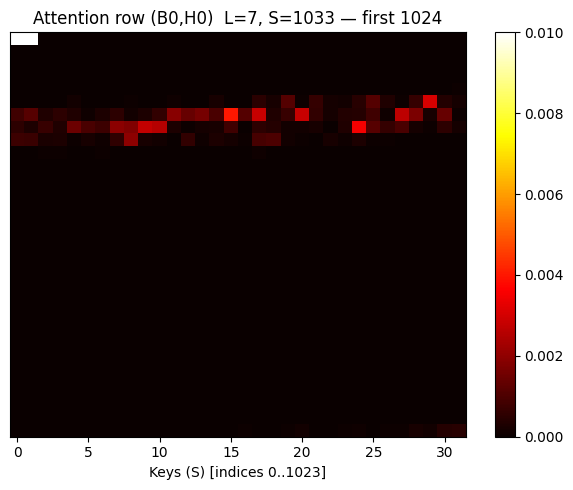

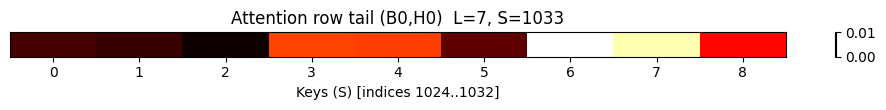

Plotting attention row map for token 1033 generation on layer 8


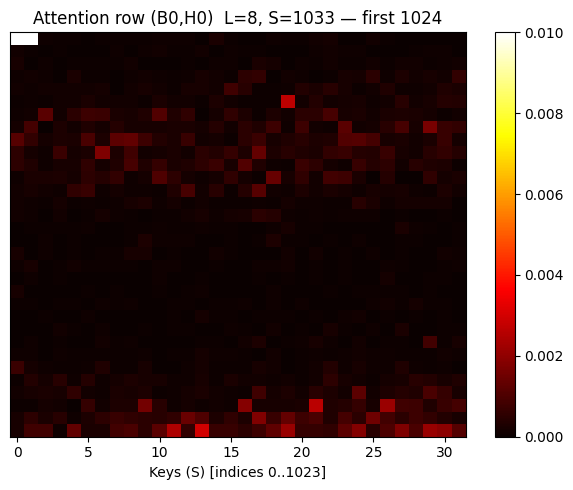

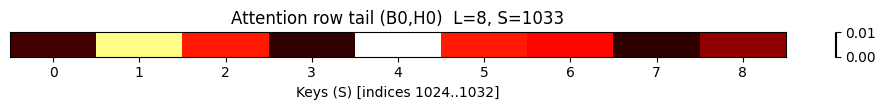

Plotting attention row map for token 1033 generation on layer 9


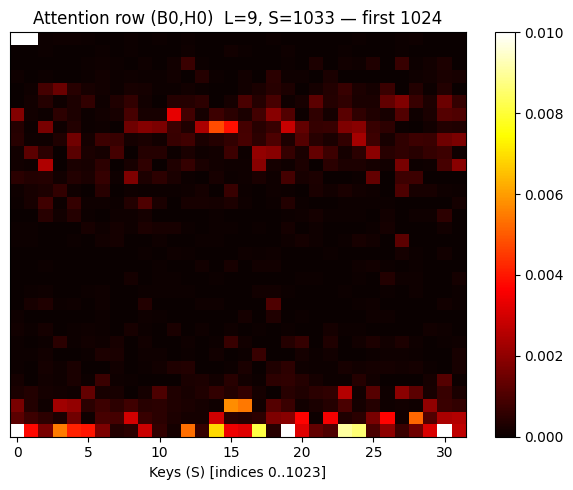

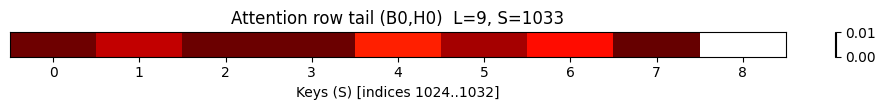

Plotting attention row map for token 1033 generation on layer 10


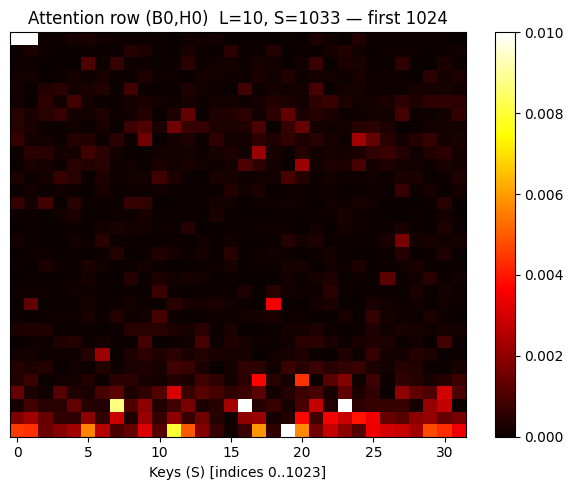

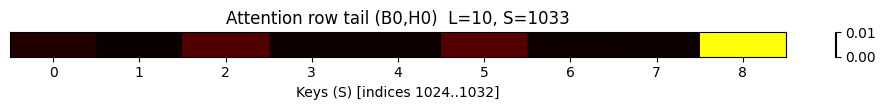

Plotting attention row map for token 1033 generation on layer 11


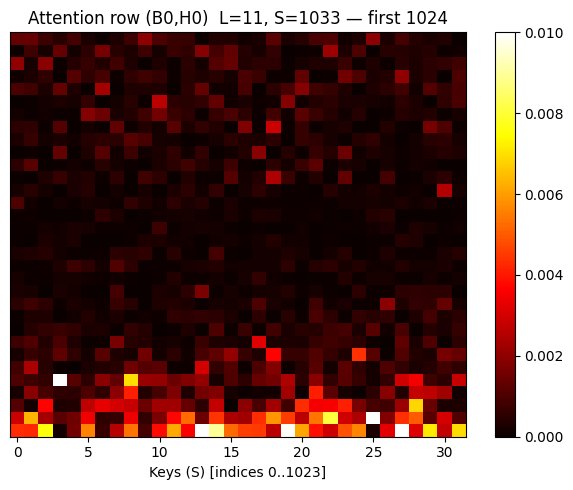

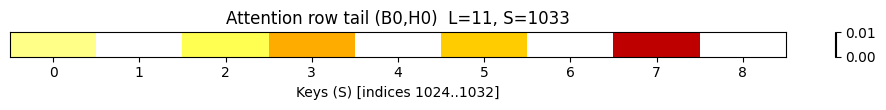

In [12]:
input_ids_length = input_ids.shape[1]
generated_token_idx = input_ids_length + 10 - 1
_ = eager_model.generate(input_ids,
                         max_new_tokens=100,
                         do_sample=False,           # False -> greedy / beams 
                         repetition_penalty=1.2,
                         eos_token_id=tokenizer.eos_token_id,
                         pad_token_id=tokenizer.pad_token_id,
                         segmentation_mask=tiled,
                         prefix_allowed_length=0,
                         plot_attention_mask=False,
                         plot_attention_map=True,
                         plot_attention_map_layer=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                         plot_attention_map_generation=generated_token_idx)